# Прогнозирование оттока клиентов фитнес-центра

## Описание проекта  
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
В нашем распоряжении файл `gym_churn.csv`, который содержит данные на месяц до оттока и факт оттока на определённый месяц.  

**Описание файла:**  

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба;
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»;
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.


**Цель исследования:**
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

**План проведения исследования:**  
- загрузить и изучить имеющиеся данные,
- провести исследовательский анализ данных,
- спрогнозировать отток посетителей методами логистической регрессии и случайного леса,
- провести кластеризацию пользователей методами агломеративной иерархической кластеризации и K-means,
- сделать выводы и дать практические рекомендации как уменьшить отток посетителей.

## Базовый анализ данных  

Изучим содержимое файла `gym_churn.csv`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    silhouette_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter('ignore')


In [ ]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [ ]:
# Приведем названия колонок к нижнему регистру
df = df.rename(columns=str.lower)

In [ ]:
print('Количество строк-дубликатов:', df.duplicated().sum())

Количество строк-дубликатов: 0


---
В датафрейме 4000 строк и 14 колонок.  <br/>
Пропусков и дубликатов нет.  <br/>
Типы данных - целые или вещественные числа (`int64`, `float64`).  <br/>
Наименования колонок мы привели в соответствие со snake_case.

---

## Исследовательский анализ данных

### Общий обзор

In [ ]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


---
Из таблицы можем заключить, что 7 переменных имеют значения от 0 до 1 (категориальные переменные). Остальные 7 - количественные.  

27% посетителей покинули фитнес-центр.  

Кроме того, можем отметить следующие наблюдения:
- посетители разделены по полу примерно одинаково,
- средний возраст - около 29 лет,
- средний "клиентский стаж" (Lifetime) посетителей - около 3 месяцев,
- среднее количество посещений - около 2 раз в неделю,
- тратит около 136 - 147 денежных единиц на дополнительные услуги,
- около 85% послетителей живет вблизи фитнес- центра,
- около половины посетителей - сотрудники компаний-партнеров,
- около 31% - использовали промокод от друга при регистрации,
- почти все посетители оставили свой контактный телефон,
- около 41% посетителей ходят на групповые занятия.


---

Рассмотрим средние значения признаков с разделением посетителей на группы - оставшиеся (0) и ушедшие(1):

In [ ]:
df.groupby(['churn']).mean().T.round(2)


churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


---
Из таблицы видим, что клиенты, продолжающие пользоваться услугами фтинес-центра, чаще:
- живут поблизости,
- работают в компании-партнере,
- пришли по акции "приведи друга",
- покупают средне- или долгосрочные абонементы,
- посещают фитнес-центр в неделю,
- посещают групповые занятия,
- имеют более длительный lifetime,
- тратят больше денег на дополнительные услуги.
---

### Анализ категориальных переменных

Ранее мы установили, что 27% посетителей перестали приходить в фитнес-центр. Рассмотрим их характеристики внимательнее.  
Напишем функции для построения графиков в виде столбчатых диаграмм.

In [ ]:
def barplot(data, x, y, title, xlabel, ylabel, legend, color):
    ax = data.plot(x, y, kind='bar', figsize=(6, 4), legend=legend, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.show()

Напишем фнукцию, которая будет выводить таблицу с соотношением количества ушедших посетителей и общего количества посетителей в зависимости от рассматриваемого признака, а также визуализировать эту информацию на графиках.

In [ ]:
def categorical(feature):
    temp = df.groupby(feature).agg({'churn': ['count', 'sum']}).reset_index()
    temp.columns = [feature, 'total_clients', 'churn_clients']
    temp['churn_rate'] = round(temp['churn_clients'] / temp['total_clients'], 2)
    print(temp)
    title = f"Соотношение общего количества клиентов и количества ушедших клиентов \n в зависимости от '{feature}'"
    xlabel = 'Признак'
    ylabel = 'Количество клиентов'
    barplot(temp, feature, ['total_clients', 'churn_clients'], title, xlabel, ylabel, True, None)
    title = f"Доля ушедших клиентов в зависимости от '{feature}'"
    ylabel = 'Доля ушедших клиентов'
    barplot(temp, feature, 'churn_rate', title, xlabel, ylabel, True, 'coral')

#### `Gender`

   gender  total_clients  churn_clients  churn_rate
0       0           1959            519        0.26
1       1           2041            542        0.27


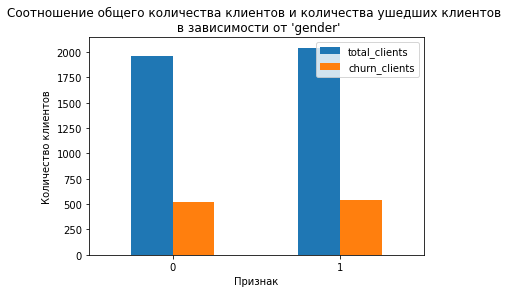

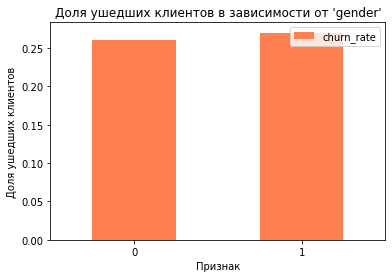

In [ ]:
categorical('gender')

Мы видим, что доли ушедших клиентов в зависимости от пола примерно одинаковые. Можем сделать вывод, что этот призная не влияет на отток клиентов, но мы не будем исключить его из дальнейшего рассмотрения.


<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>

В целом и в среднем да, признак не влияет. Однако пока сложно сказать, будет ли он влиять при условии третьих признаков или будет ли та же ситуация для разных кластеров. В модельки советую этот признак взять.
    
Но вообще сложно не согласиться, что признак не выглядит сколько-нибудь влияющим.
       
</div>
  

<div class="alert alert-info">
Ок, я оставил Gender в дальнейших расчетах.
</div>

#### `Near_location`

   near_location  total_clients  churn_clients  churn_rate
0              0            619            246        0.40
1              1           3381            815        0.24


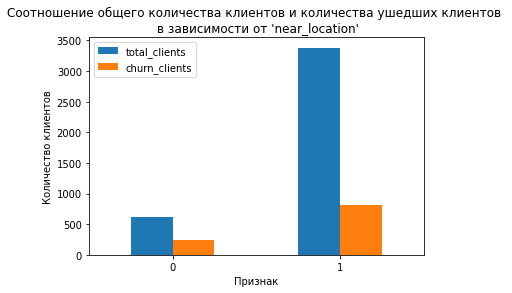

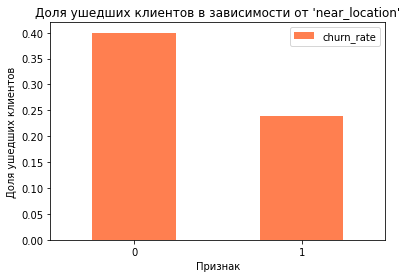

In [ ]:
categorical('near_location')

Как мы видим, посетители в большинстве своем живут рядом с фитнес-центром. Среди людей, живущих в отдалении от фитнес-центра, доля ушедших клиентов примерно в полтора раза выше, чем среди тех, кто живёт поблизости.

#### `Partner`

   partner  total_clients  churn_clients  churn_rate
0        0           2053            684        0.33
1        1           1947            377        0.19


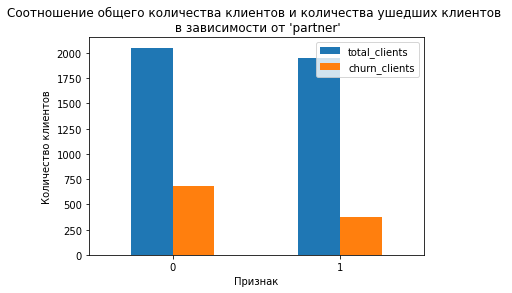

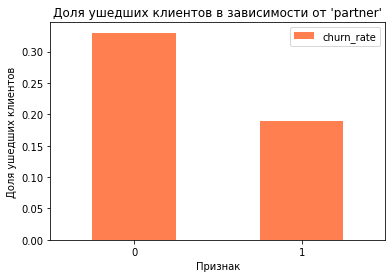

In [ ]:
categorical('partner')

Посетителеи делятся на практически равные группы - сотрудники компаний-партнеров и прочие посетители. Однако, отток прочих постетителей почти в 1,7 раз больше, чем отток сотрудников компаний-партнеров.

#### `Promo_friends`

   promo_friends  total_clients  churn_clients  churn_rate
0              0           2766            866        0.31
1              1           1234            195        0.16


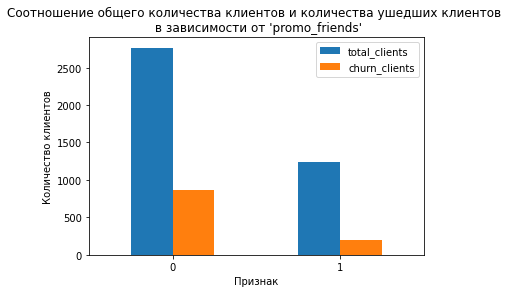

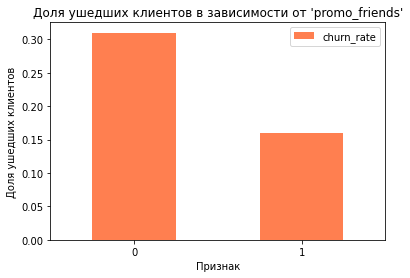

In [ ]:
categorical('promo_friends')

Отток посетителей, использовавших промо-код от знакомого при оплате первого абонемента, почти в два раза меньше, чем отток прочих посетителей.

#### `Phone`

   phone  total_clients  churn_clients  churn_rate
0      0            386            103        0.27
1      1           3614            958        0.27


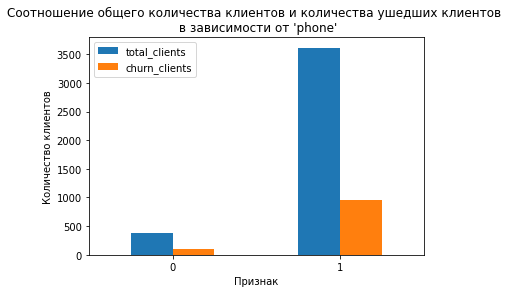

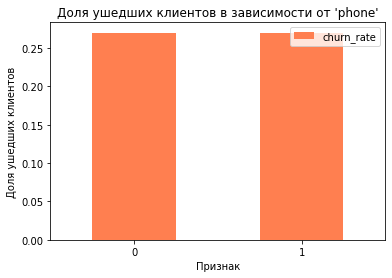

In [ ]:
categorical('phone')

Как мы видели ранее, около 90% постетителей оставили свой контактный телефон при регистрации.
Наличие номера телефона не влияет на отток - уровень оттока пользователей в обоих случаях примерно одинаковый.

#### `Contract_period`

   contract_period  total_clients  churn_clients  churn_rate
0                1           2207            934        0.42
1                6            833            104        0.12
2               12            960             23        0.02


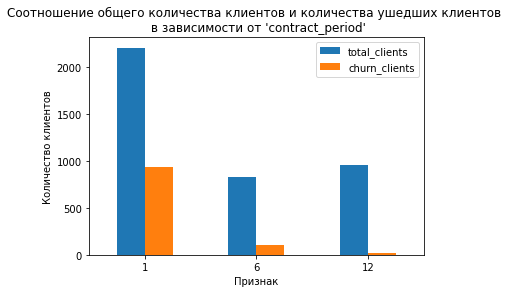

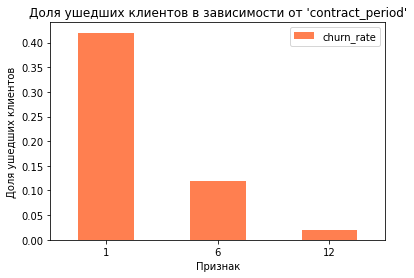

In [ ]:
categorical('contract_period')

У нас есть три типа абоненментов - на 1, 6 и 12 месяцев. Длительность абонемента существенно влияет на уровень оттока - чем больше длительность абонемента, тем меньше уровень оттока.

#### `Group_visits`

   group_visits  total_clients  churn_clients  churn_rate
0             0           2351            776        0.33
1             1           1649            285        0.17


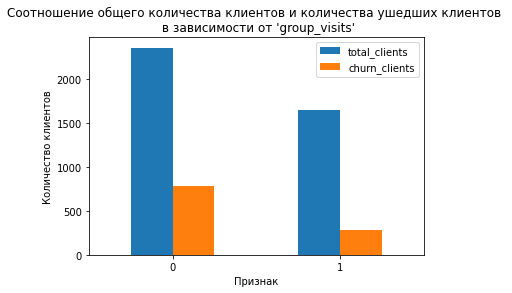

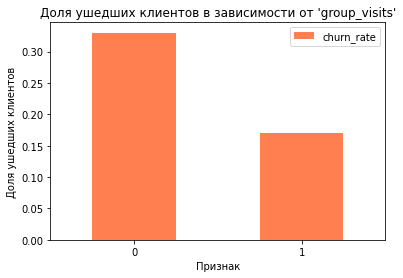

In [ ]:
categorical('group_visits')

Групповые занятия посещают менее половины всех посетителей (около 41%), но этот показатель влияет на отток - доля ушедших посетителей, посещавших групповые занятия примерно в два раза меньше доли пользователей, не посещавших групповые занятия.

### Анализ количественных переменных

Зададим функции для построения гистограмм и диаграмм размаха для количественных переменных.

In [ ]:
def histogram(feature, title, xlabel, ylabel, bins):
    plt.figure(figsize=(8, 4))
    plt.hist(df[feature], bins, label='total_clients')
    plt.hist(df.query('churn == 1')[feature], bins, label='churn_clients')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
def boxplot(feature, title, ylabel):
    plt.figure(figsize=(8, 4))
    plt.boxplot([df[feature], df.query('churn == 1')[feature]])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks([1, 2], ['total_clients', 'churn_clients'])
    plt.show()

Зададим функцию, строящие графики и выводящие средние и медианные значения количественных признаков.

In [ ]:
def numerical(feature, bins):
    title = f"Распределение всех клиентов и ушедших клиентов \n в зависимости от '{feature}'"
    xlabel = 'Значение признака'
    ylabel = 'Количество клиентов'
    histogram(feature=feature, title=title, xlabel=xlabel, ylabel=ylabel, bins=bins)
    boxplot(feature, title, ylabel=xlabel)
    print(f'Среднее значение признака для всех клиентов: {round(df[feature].mean(), 1)}')
    print(f'Медиана признака для всех клиентов: {round(df[feature].median(), 1)}')
    print(f'Среднее значение признака для ушедших клиентов: {round(df.query("churn == 1")[feature].mean(), 1)}')
    print(f'Медиана признака для ушедших клиентов: {round(df.query("churn == 1")[feature].median(), 1)}')


####  `Age`

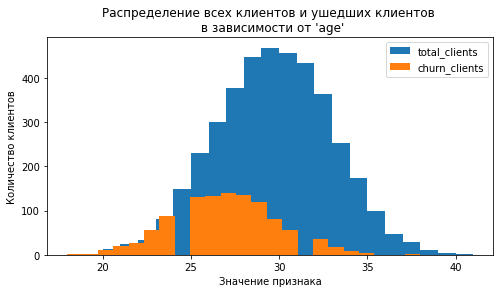

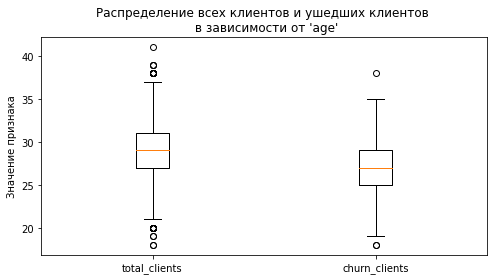

Среднее значение признака для всех клиентов: 29.2
Медиана признака для всех клиентов: 29.0
Среднее значение признака для ушедших клиентов: 27.0
Медиана признака для ушедших клиентов: 27.0


In [ ]:
numerical('age', 23)

---
Интенсивнее отток более молодых клиентов - в возрасте в среднем около 27 лет.  
Чем старше посетитель, тем меньше вероятность его оттока. Посетители старше 35 лет уходят довольно редко.

---

#### `Month_to_end_contract`

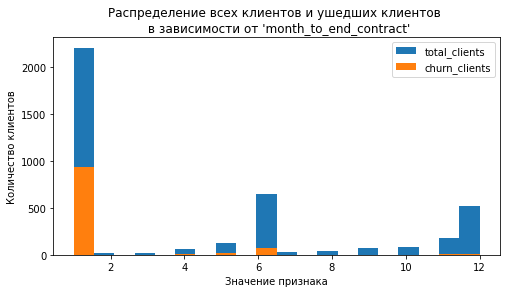

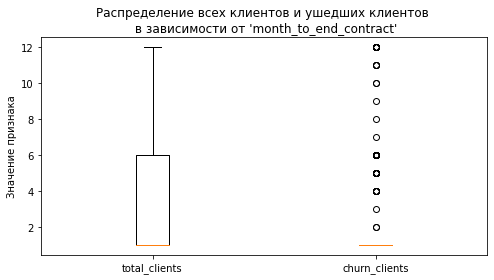

Среднее значение признака для всех клиентов: 4.3
Медиана признака для всех клиентов: 1.0
Среднее значение признака для ушедших клиентов: 1.7
Медиана признака для ушедших клиентов: 1.0


In [ ]:
numerical('month_to_end_contract', 20)

---
Наибольшая вероятность оттока у посетителей, чей абонемент заканчивается примерно через месяц.

---

#### `Lifetime`

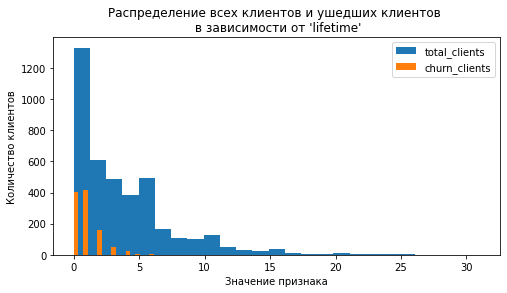

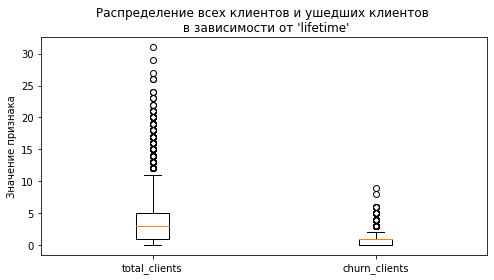

Среднее значение признака для всех клиентов: 3.7
Медиана признака для всех клиентов: 3.0
Среднее значение признака для ушедших клиентов: 1.0
Медиана признака для ушедших клиентов: 1.0


In [ ]:
numerical('lifetime', 25)

---
На графиках видим:
- уходят преимущественно те клиенты, которые посещали фитнес-центр менее двух месяцев,
- клиенты, которые посещают в фитнес-центр более 10 месяцев, не уходят.

---

#### `Avg_class_frequency_total`

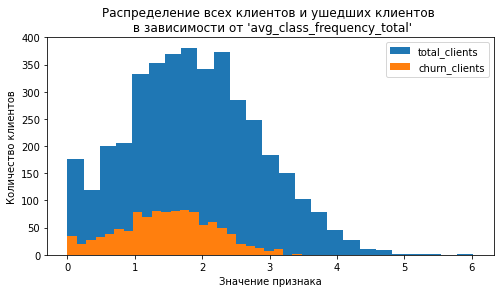

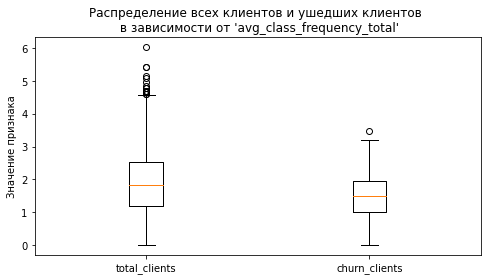

Среднее значение признака для всех клиентов: 1.9
Медиана признака для всех клиентов: 1.8
Среднее значение признака для ушедших клиентов: 1.5
Медиана признака для ушедших клиентов: 1.5


In [ ]:
numerical('avg_class_frequency_total', 25)

---
Чем чаще посетитель ходит в фитнес-центр в течение недели, тем меньше вероятность его оттока. Посетители, которые ходят более 4 раз в неделю, не попадают в отток.

---

#### `Avg_class_frequency_current_month`

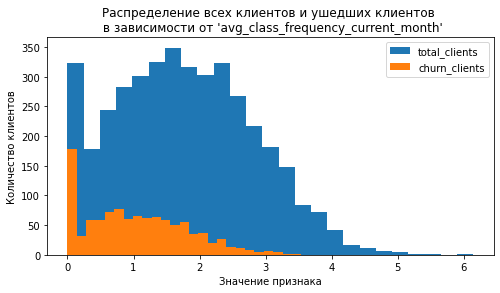

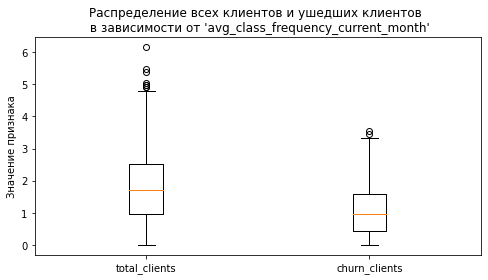

Среднее значение признака для всех клиентов: 1.8
Медиана признака для всех клиентов: 1.7
Среднее значение признака для ушедших клиентов: 1.0
Медиана признака для ушедших клиентов: 1.0


In [ ]:
numerical('avg_class_frequency_current_month', 25)

---
В последний месяц подавляющее большинство ушедших клиентов не посещали фитнес-центр.  
Здесь сразу можно дать рекомендацию мониторить, посещает ли человек фитнес-клуб. И если нет, заинтересесовать и замотивировать такого клиента.

---

#### `Avg_additional_charges_total`

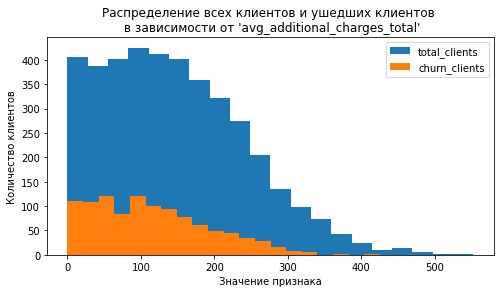

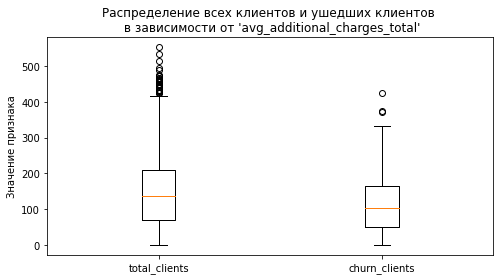

Среднее значение признака для всех клиентов: 146.9
Медиана признака для всех клиентов: 136.2
Среднее значение признака для ушедших клиентов: 115.1
Медиана признака для ушедших клиентов: 103.8


In [ ]:
numerical('avg_additional_charges_total', 20)

---
Траты на дополнительные услуги ушедших посетителей меньше, чем траты оставшихся.  
Ушедшие клиенты тратили на дополнительные услуги не более 400 условных денежных единиц.

---

### Матрица корреляций

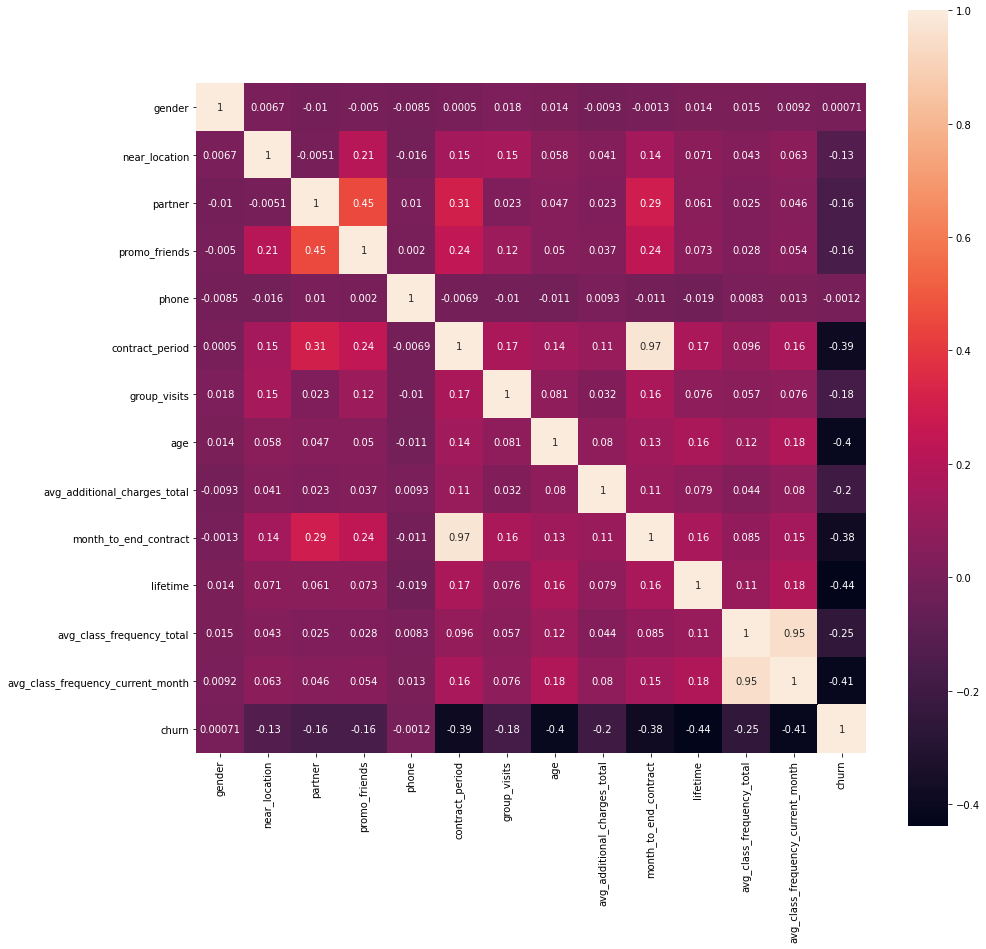

In [ ]:
cm =  df.corr()

plt.figure(figsize = (15,15))
sns.heatmap(cm, square = True, annot = True)
plt.show()

Мы можем сделать следующие выводы:

- ни один признак не оказывает сильного влияния на отток посетителей,
- наибольшую корреляцию с оттоком посетителей имеет признак `Lifetime`,
- далее по степени корреляции следуют признаки `Age`, `Contract_period` и `Avg_class_frequency_current_month`.
- упомянутые выше признаки имеют отрицательную корреляцию с оттоком, т.е., чем больше значение признаков, тем меньше вероятность оттока постетителей,
- признаки `Gender` и `Phone` практически  не влияют на отток постетителей,
- признаки `Contract_period` и `Month_to_end_contract`, а также `Avg_class_frequency_total` и `Avg_class_frequency_current_month` ожидаемо имеют сильную взаимную корреляцию (т.н. мультиколлинеарность).


## Модель прогнозирования оттока клиентов

Сначала проведем предварительную подготовку данных для моделирования оттока клиентов.  
Удалим из исходного датафрейма колонки `Month_to_end_contract` и `Avg_class_frequency_current_month` из-за мультиколинеарности.


In [ ]:
df = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

### Логистическая регрессия

In [ ]:
# Разделим данные на матрицу признаков X и целевую переменную y:
X = df.drop('churn', axis = 1)
y = df['churn']

# Разделим модель на обучающую и валидационную выборку:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# Зададим алгоритм для модели:
lr_model = LogisticRegression()

# Обучим модель:
lr_model.fit(X_train, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы:
lr_predictions = lr_model.predict(X_test)

### Случайный лес

In [ ]:
# Создадим объект класса StandardScaler и применим его к обучающей выборке:
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# Зададим алгоритм для модели на основе алгоритма случайного леса:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучим модель:
rf_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы:
rf_predictions = rf_model.predict(X_test_st)

### Оценка качества прогнозов

Зададим функцию, при помощи которой выведем метрики для оценки качества прогнозов:

In [ ]:
def metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.3f}'.format(f1_score(y_true, y_pred)))

In [ ]:
metrics(y_test, lr_predictions, 'Метрики для логистической регрессии:')
metrics(y_test, rf_predictions, title = 'Метрики для случайного леса:')

Метрики для логистической регрессии:
	Accuracy: 0.890
	Precision: 0.792
	Recall: 0.792
	F1: 0.792
Метрики для случайного леса:
	Accuracy: 0.894
	Precision: 0.807
	Recall: 0.788
	F1: 0.797


---
Как мы видим:
1. Accuracy (доля правильных ответов) для случайного леса (0.894) выше, чем для логистической регрессии (0.890). Это означает, что случайный лес правильно классифицирует большее количество образцов.
2. Precision (точность) для случайного леса (0.807) также выше, чем для логистической регрессии (0.792). Это означает, что случайный лес имеет меньше ложно-положительных результатов.
3. Recall (полнота) для логистической регрессии (0.792) и случайного леса (0.788) примерно одинаковы. Это означает, что обе модели способны правильно идентифицировать примерно одинаковое количество положительных образцов.
4. F1-мера, которая учитывает и точность, и полноту, для случайного леса (0.797) выше, чем для логистической регрессии (0.792).

Можем сделать вывод, что случайный лес показывает немного лучшие результаты по сравнению с логистической регрессией.

---

## Кластеризация клиентов

### Агломеративная иерархическая кластеризация

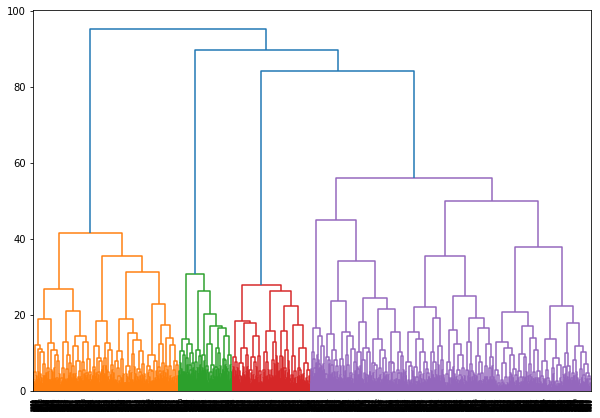

In [ ]:
# Выделим данные для кластеризации:
X = df.drop('churn', axis = 1)

# Стандартизируем:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Строим таблицу расстояний между объектами:
linked = linkage(X_sc, method = 'ward')

# Строим дендрограмму:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.show()

---
Данные разделились на 4 кластера, один из которых значительно больше других.  
Разобъем данные на 5 кластеров при помощи алгоритма K-Means.

---

### K-Means

In [ ]:
km = KMeans(n_clusters = 5, random_state = 0)

# Прогнозируем кластеры для наблюдений:
labels = km.fit_predict(X_sc)

# Cохраняем метки кластера в поле датасета:
df['cluster_km'] = labels

print('Размеры кластеров:')
df.groupby('cluster_km').agg(count=('age','count'))

Размеры кластеров:


,count
cluster_km,
0,561
1,1050
2,1132
3,871
4,386


In [ ]:
# Выведем статистику по средним значениям наших признаков по кластеру, в том числе и :
df.groupby('cluster_km').agg('mean').T.round(2)

cluster_km,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
lifetime,3.06,4.38,3.34,3.76,3.94


In [ ]:
# Создадим вспомогательный датафрейм для дальнейших визуализаций.
churn_clusters = df.groupby('cluster_km').agg('mean').reset_index()

In [ ]:
# Задаим функцию для построения столбчатых диаграмм
def cluster_barplot(feature):
    churn_clusters.plot(x='cluster_km', y=feature, kind='bar', figsize=(8, 4), alpha=.8, legend=False)
    plt.title(f"Среднее значение признака '{feature}' в кластерах")
    plt.xlabel('Кластер')
    plt.ylabel('Значение признака')
    plt.xticks(rotation=0)
    plt.show()

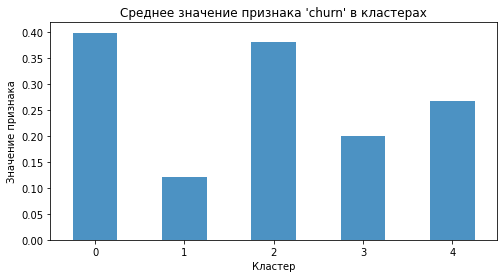

In [ ]:
cluster_barplot('churn')

---
В нулевом и втором кластерах сгруппированы наиболее подверженные оттоку посетители. Процент их оттока, соответственно, 40% и 38%.     
В первом кластере - наиболее лояльные посетители. Их отток оцениваем в 12%.

---

In [ ]:
# Посчитаем метрику силуэта для нашей кластеризации:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


---
Значение метрики Silhouette Score (оценка качества кластеризации данных) равно 0.14.  
Оно невысокое и говорит о среднем качестве кластеризации. Кластеры имеют некоторую степень разделения, но могут быть лучше.

---

Визуализируем значения **категориальных признаков** по кластерам.

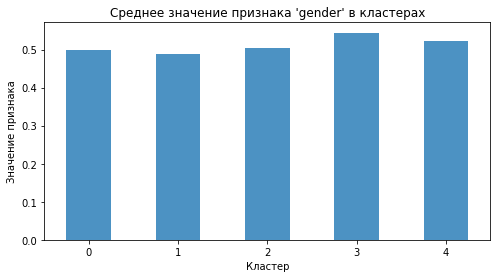

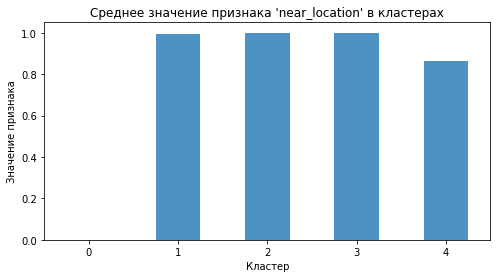

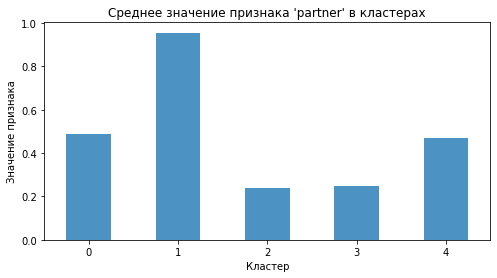

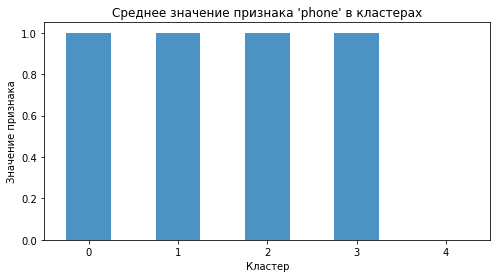

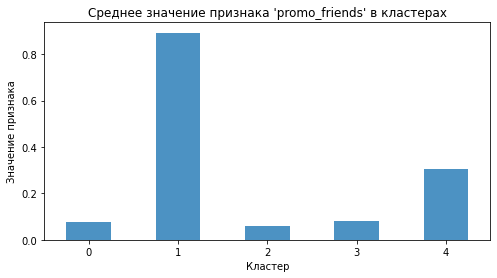

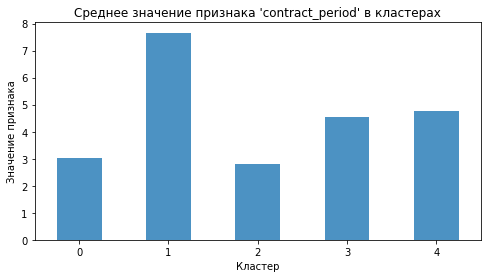

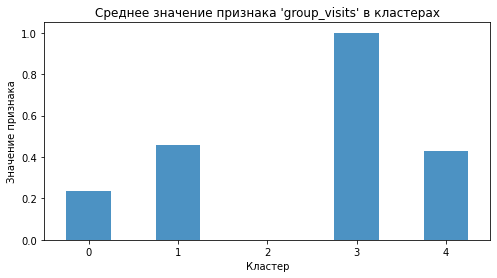

In [ ]:
categorical = ['gender', 'near_location', 'partner', 'phone', 'promo_friends', 'contract_period', 'group_visits']
for feature in categorical:
    cluster_barplot(feature)

---
Зададим функцию для построения диаграмм размаха и визуализируем **количественные признаки**.

In [ ]:
def cluster_boxplot(feature):
    plt.figure(figsize=(8, 4))
    plt.boxplot([df.query('cluster_km == 0')[feature], df.query('cluster_km == 1')[feature],
                 df.query('cluster_km == 2')[feature], df.query('cluster_km == 3')[feature],
                 df.query('cluster_km == 4')[feature]])
    plt.title(f"Распределение клиентов в кластерах в зависимости от \n '{feature}'")
    plt.xlabel('Кластер')
    plt.ylabel('Значение признака')
    plt.xticks([1, 2, 3, 4, 5], [0, 1, 2, 3, 4])
    plt.show()

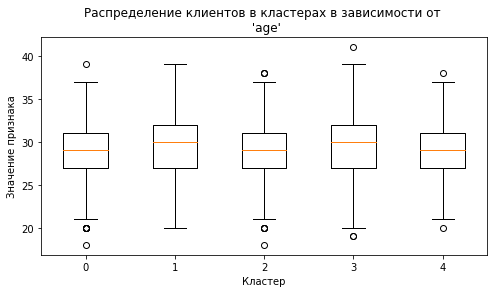

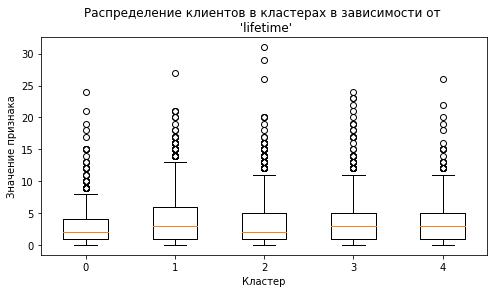

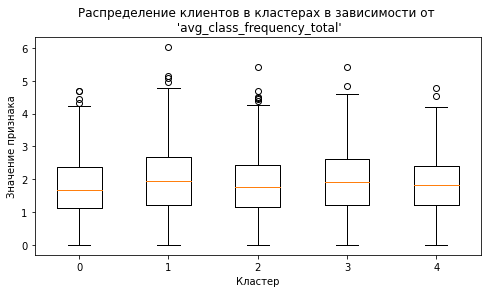

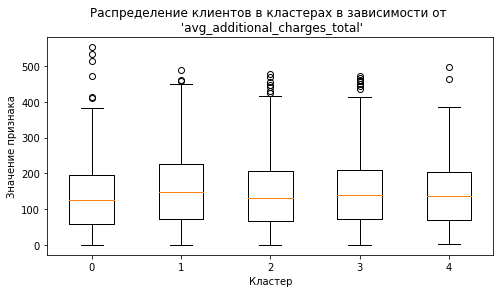

In [ ]:
numerical = ['age', 'lifetime', 'avg_class_frequency_total',
             'avg_additional_charges_total']

for feature in numerical:
    cluster_boxplot(feature)

---
Можем заметить **примерно одинаковые признаки** для всех кластеров:
- примерно одинаковое распределение по полу,
- средний возраст посетителей во всех кластерах варьируется в узком диапазоне от 28,5 до 29,5 лет,
- показатель Lifetime - в диапазоне от 3 до 4,5 месяцев,
- частота посещений - почти по 2 визита в неделю

Кроме того, можем выделить следующие основные особенности кластеров:  

**Кластер 0 - "Живущие далеко":**
- высокий процент оттока посетителей (40%),
- все живут далеко от фитнес-центра,
- примерно половина - сотрудники компаний-партнеров - 49%,
- лишь 8% пришли по промокоду от друзей,
- срок действия абонементов - в среднем 3 месяца,
- почти четверть (24%) посещает групповые тренировки,
- самый низкий уровень дополнительных трат.


**Кластер 1 - "Друзья и партнеры":**
- самый низкий отток постетителей (12%),
- довольно многочисленный кластер - 1050 посетителей,
- все живут рядом с фитнес-центром,
- большинство (96%) - сотрудники компаний-партнеров,
- большинство (89%) пришли по рекомендации друзей,
- самая большая длительность абонемента - в среднем более 7,5 месяцев,
- почти половина (46%) посещает групповые тренировки.


**Кластер 2 - "Без групповых тренировок":**
- высокий процент оттока посетителей (38%),
- самый многочисленный кластер - 1132 посетителя,
- все посетители живут рядом с фитнес-центром,
- почти четверть (24%) - сотрудники компаний-партнеров,
- самый низкий процент среди пришедших по рекомендации друзей - 6%,
- самый короткий средний срок действия абонемента - менее 3 месяцев,
- никто не посещает групповые тренировки,
- низкий уровень дополнительных трат.


**Кластер 3 - "С групповыми тренировками":**  
- умеренный процент оттока - 20%,
- все посетители живут рядом с фитнес-центром,
- четверть посетителей (25%) - сотрудники компаний-партнеров,
- низкий процент среди пришедших по рекомендации друзей - 8%,
- длительнось абонементов - около 4,5 месяцев,
- все посещают групповые тренировки.


**Кластер 4 - "Без телефона":**
- умеренный процент оттока - 27%,
- никто из посетителей не оставил свой контактный телефон,
- живут преимущественно рядом с фитнес-центром (86%),
- почти половина (47%) - сотрудников компаний-партнеров,
- почти треть (31%) - пришли по рекомендации друзей,
- длительнось абонементов - более 4,5 месяцев,
- 43% посещают групповые тренировки.


## Выводы и рекомендации

1. Мы провели исследование поведения 4000 посетителей фитнес-центра и проанализировали их склонность к прекращению пользования услугами фитнес-центра на основании 13 признаков.
2. Определили основные характеристики посетителей:
    - посетители разделяются по полу примерно в равных долях,
    - возраст - от 18 до 41 года (в среднем - 29 лет),
    - большинство (85%) живет рядом с фитнес-центром,
    - около половины посетителей - сотрудники компаний-партнеров,
    - 31% воспользовались промокодом от друзей,
    - есть абонементы на 1, 6 и 12 месяцев,
    - средний срок действия абонемента у пользователей - около 4,5 месяцев,
    - в среднем продолжительность посещений с момента первого визита составляет около 3,5 месяцев,
    - средняя частота посещений - около 2 раз в неделю,
    - на дополнительные кслуги тратят 147 условных денежных единиц,
    - процент оттока посетителей - 27%.
3. Наибольшее влияние на отток пользователей имеют признаки `Lifetime`, `Age`, `Contract_period` и `Avg_class_frequency_current_month`.
4. Признаки `Gender` и `Phone` практически не влияют на отток постетителей.
5. Признаки `Contract_period` и `Month_to_end_contract`, а также `Avg_class_frequency_total` и `Avg_class_frequency_current_month` имеют сильную взаимную корреляцию.
6. Мы спрогнозировали отток посетителей методами логистической регрессии и случайного леса.
7. Наибольшую точность показала модель случайного леса.
8. Методом агломеративной иерархической кластеризации сгруппировали клиентов в 4 кластера.
9. Методом K-Means детализировали разделение клиентов на 5 кластеров.
10. Проанализировали каждый кластер в результате получили  портрет лояльного посетителя и посетителя, склонного к оттоку:  

**Лояльный посетитель:**
- возраст около 30 лет,
- живет рядом с фитнес-центром,
- имеет долгосрочный абонемент,
- посещает фитнес-центр более 4 месяцев с регулярностью 2-3 раза в неделю,
- посещает групповые занятия,
- пользуется дополнительными услугами.

**Склонный к оттоку посетитель:**
- возраст менее 30 лет,
- живет в удалении от фитнес-центра,
- имеет красткосрочный абонемент,
- посещает фитнес-центр менее 3 месяцев с регулярностью около 1 раза в неделю,
- редко посещает групповые занятия,
- редко пользуется дополнительными услугами.

На основании сделанных выводов можем дать **общие рекомендации:**
1. Увеличить узнаваемость фитнес-центра и сформировать его превосходную репутацию среди местных жителей:
- дать наружную рекламу (установка баннеров, раздача листовок) в местах массового скопления людей в районе (у станций метро, в крупных магазинах и т.п.),
- стать информационным спонсором локальных спортивных сообществ и мероприятий (например, местного забега "5 верст"),
- самостоятельно организовывать бесплатные или недорогие открытые тренировки, мастер-классы, соревнования в подходящей локации рядом с фитнес-центром,
- создать канал в Telegram или VK, посвященный фитнесу, ЗОЖ, коммуникациям со своими клиентами и рекламировать его в местных популярных пабликах.
2. Стимулировать посетителей приобретать долгосрочные абонементы:
- сделать дополнительные виды абонементов на 2 и 3 месяца,
- давать один дополнительный месяц бесплатного посещения фитнес-центра при покупке краткосрочных абонементов (на 1, 2 или 3 месяца),
- ввести прогрессивные скидки на средне- и долгосрочные абонементы - чем дольше непрерывное посещение, тем больше скидка.
3. Сделать акцент на удержание посетителей:
- через собственный персонал или собственные соцсети активно демонстрировать преимущества регулярных посещений и занятий с опытным тренером - улучшение здоровья и самочувствия, отличная форма, безупречная фигура, увеличение работоспособности и, как следствие, карьерный и зарплатный рост,
- сделать акцент на высокую эффективность и инновационность тренажеров,
- бесплатно при помощи профессионального тренера составлять индивидуальную долгосрочную программу тренировок для достижения желаемого эффекта с возможностью отслежтвания прогрсса,
- продолжать акцию "приведи друга" и сотрудничество с компаниями-партнерами. Это позволит приходить новым клиентам не одним, а вместе со знакомым человеком (другом, родственником или коллегой).
4. Стимулировать клиентов посещать групповые занятия и увеличить частоту посещений:
- проанализировать свой опыт и опыт конкурентов, выявить наиболее востребованные виды тренировок и распланировать их на максимально удобное для клиентов время,
- тщательнее подбирать тренеров - нанять харизматичных тренеров групповых тренировок, которые могут увлечь и удержать посетителей,
- организовывать и широко рекламировать совместные тренировки с известными медийными людьми (особенно со знаменитыми спортсменами).
5. Мотивировать посетителей пользоваться дополнительными услугами:
- проанализировать и постараться удовлетворить потребности посетителей, какими дополнительными услугами они хотели бы воспользоваться при посещении фитнес-центра (например, массаж, консультация физиотерапевта или нутрициолога, продажа собственной брендированной продукции, спротивных аксессуаров, витаминов и БАДов и т.п.)
- убедить посетителей, что доп. услуги многократно увеличивают эффект обычного занятия в центре,
- предоставлять существенные скидки на первое использование доп. услуг.


Также можем дать **рекомендации с учетом специфики** кластеров:
1. **Кластер 0 - "Живущие далеко"** - самый проблемный кластер. Видится разумным добавить максимум комфорта посетителям, которые тратят много времени на путь до фитнес-центра.
- возможно, эти клиенты работают неподалеку, и для них можно сделать, например, утренний иои дневной абонемент, чтобы они смогли прийти либо перед работой, либо в обеденный перерыв,
- можно организовать зону кафе с фитнес-меню, чтобы эти кпосетители смогли заодно позавтракать или пообедать,
- можно предоставить 1-2 часа бесплатной парковки около фитнес-центра,
- нужно стремиться увеличить совместные походы в фитнес-центр - предложить скидки на посещения с друзьями или с семьей.
2. **Кластер 1 - "Друзья и партнеры"** - самые лояльные посетители.
- в качестве поощрения и благодарности за лояльность можно предлагать небольшие случайные бонусы - брендированное полотенце в подарок, разовая скидка на долгосрочный абонемент,  1 бесплатный массаж, 1 бесплатный смузи в фитнес-кафе и т.д.
3. **Кластер 2 - "Без групповых тренировок"** - проблемный и многочисленный кластер. Стоит сфокусироваться на увеличении совместных посещений, что может привести к увлечению групповыми тренировками:
- можно организовать возможность оставить детей в игровой зоне, чтобы можно было бы приходить всей семьей или коллективом декретниц,
- заключить партнерские соглашения с большим количеством работающих неподалеку организаций, чтобы можно было прихордить с коллегами.
4. **Кластер 3 - "С групповыми тренировками"**  - не самый проблемный кластер. Для него можно провести те же мероприятия, которые предлагались для Кластера 2 - это поможет увеличить доли поестителей - сотрудников компаний-партнеров и посетителей, поспользоваошимися промокодами от друга.
5. **Кластер 4 - "Без телефона"** - довольно загадочный кластер. Можем предположить, что если посетители не оставили свой контактный телефон, то они либо очень осторожны и осмотрительны в предоставлении персональной информации, либо у них есть четкая цель посещений фитнес-центра и они не хотят звонков с дополнительными напоминаниями и рекламой.
- можно осторожно попробовать предложить этим посетителям услугу по составлению индивидуального пошагового плана занятий с отслеживанием прогресса и периодической корректировкой,
- можно предложить дополнительную услугу периодического биоимпедансного анализа состава тела при помощи специального оборудования.